In [75]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd
import numpy as np
import random
import os
os.environ['R_HOME'] = 'C:\Programming\R\R-4.4.2'

In [76]:
# 재현성 난수 고정
SEED = 100

os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

random.seed(SEED)
np.random.seed(SEED)

In [77]:
# data load
df_name = 'esol'
df = pd.read_csv('C:\Programming\Github\EGCN\data\\' + df_name + '.csv')

smiles_list = df['smiles'].tolist()

# target 정의
target = df.iloc[:,-1]

print(smiles_list[:5])
print(target[:5])

['OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O', 'Cc1occc1C(=O)Nc2ccccc2', 'CC(C)=CCCC(C)=CC(=O)', 'c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43', 'c1ccsc1']
0   -0.77
1   -3.30
2   -2.06
3   -7.87
4   -1.33
Name: logp, dtype: float64


In [78]:
# 분자 특성 추출 class
class MolecularFeatureExtractor:
    def __init__(self):
        self.descriptors = [desc[0] for desc in Descriptors._descList]

    def extract_molecular_features(self, smiles_list):
        features_dict = {desc: [] for desc in self.descriptors}

        for smiles in smiles_list:
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                for descriptor_name in self.descriptors:
                    descriptor_function = getattr(Descriptors, descriptor_name)
                    try:
                        features_dict[descriptor_name].append(descriptor_function(mol))
                    except:
                        features_dict[descriptor_name].append(None)
            else:
                for descriptor_name in self.descriptors:
                    features_dict[descriptor_name].append(None)

        return pd.DataFrame(features_dict)

In [79]:
# 분자 특성 추출 및 데이터프레임 정의
extractor = MolecularFeatureExtractor()
df_all_features = extractor.extract_molecular_features(smiles_list)

df_all_features['target'] = target
df_all_features.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,target
0,10.253329,-1.701605,10.253329,0.486602,0.217518,457.432,430.216,457.158411,178,0,...,0,0,0,0,0,0,0,0,0,-0.77
1,11.724911,-0.145880,11.724911,0.145880,0.811283,201.225,190.137,201.078979,76,0,...,0,0,0,0,0,0,0,0,0,-3.30
2,10.020498,0.845090,10.020498,0.845090,0.343706,152.237,136.109,152.120115,62,0,...,0,0,0,0,0,0,0,0,0,-2.06
3,2.270278,1.301055,2.270278,1.301055,0.291526,278.354,264.242,278.109550,102,0,...,0,0,0,0,0,0,0,0,0,-7.87
4,2.041667,1.712963,2.041667,1.712963,0.448927,84.143,80.111,84.003371,26,0,...,0,0,0,0,0,0,1,0,0,-1.33


# t-sne

In [80]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

## 사분위수

In [81]:
Q1 = np.percentile(target, 25)
Q2 = np.percentile(target, 50)
Q3 = np.percentile(target, 75)

idx_Q1 = np.where(target < Q1)[0]
idx_Q2 = np.where((target >= Q1) & (target < Q2))[0]
idx_Q3 = np.where((target >= Q2) & (target < Q3))[0]
idx_Q4 = np.where(target >= Q3)[0]

print(Q1, Q2, Q3)
print(idx_Q1, idx_Q2, idx_Q3, idx_Q4)

-4.3175 -2.86 -1.6
[   3    6    7    8    9   14   20   21   24   28   31   32   34   39
   40   48   52   54   56   58   60   65   69   71   76   77   86   89
   92   96   97  101  111  114  117  118  119  121  122  124  127  129
  139  158  161  166  167  169  170  172  175  181  184  185  187  188
  195  203  211  215  218  220  222  229  234  254  259  260  261  262
  263  268  272  275  286  288  289  290  293  294  297  299  303  304
  312  316  319  321  324  336  344  353  358  360  369  382  384  389
  390  397  398  405  414  417  420  421  422  423  429  430  432  434
  444  445  447  449  450  451  453  455  456  458  472  479  482  486
  491  497  498  499  500  510  517  522  529  531  547  548  552  554
  557  558  559  560  567  579  583  586  591  593  603  611  616  622
  623  625  632  637  640  643  645  646  650  654  655  661  668  672
  675  676  681  682  686  694  700  711  716  717  718  723  725  729
  734  736  743  744  751  755  756  759  767  768  775  7

In [82]:
# 중앙값
med = np.percentile(target, 50)

idx_med1 = np.where(target < med)[0]
idx_med2 = np.where(target >= med)[0]

print(med)
print(idx_med1, idx_med2)

-2.86
[   1    3    6    7    8    9   11   14   18   19   20   21   22   24
   28   29   30   31   32   34   36   37   38   39   40   46   47   48
   50   52   54   56   57   58   60   62   65   66   69   70   71   76
   77   79   84   85   86   89   90   91   92   94   95   96   97   99
  100  101  104  110  111  112  114  117  118  119  120  121  122  124
  127  129  131  134  135  138  139  158  159  161  163  164  166  167
  169  170  172  175  180  181  182  184  185  187  188  190  195  197
  198  200  203  204  211  212  214  215  218  219  220  222  225  226
  229  232  234  235  243  244  245  247  248  254  256  258  259  260
  261  262  263  264  265  266  268  270  272  274  275  283  284  286
  288  289  290  291  293  294  296  297  299  300  303  304  305  306
  308  310  312  315  316  319  321  322  324  325  329  330  331  333
  335  336  337  338  339  340  343  344  345  347  351  353  354  357
  358  360  362  364  366  369  372  373  375  378  382  384  389  390


In [83]:
# 1/3
med1 = np.percentile(target, 33)
med2 = np.percentile(target, 66)

idx_med4 = np.where(target < med1)[0]
idx_med5 = np.where((target >= med1) & (target < med2))[0]
idx_med6 = np.where(target >= med2)[0]

print(med1, med2)
print(idx_med4, idx_med5, idx_med6)

-3.8008999999999995 -2.0850799999999996
[   3    6    7    8    9   11   14   20   21   22   24   28   31   32
   34   37   38   39   40   48   52   54   56   57   58   60   65   66
   69   71   76   77   86   89   92   94   95   96   97  101  104  111
  114  117  118  119  121  122  124  127  129  134  139  158  161  166
  167  169  170  172  175  181  184  185  187  188  195  197  203  211
  212  214  215  218  220  222  229  232  234  235  243  248  254  258
  259  260  261  262  263  266  268  272  274  275  284  286  288  289
  290  291  293  294  297  299  303  304  305  306  310  312  316  319
  321  324  330  335  336  344  347  353  357  358  360  369  375  382
  384  389  390  397  398  401  402  405  414  417  418  420  421  422
  423  424  429  430  432  434  444  445  447  449  450  451  452  453
  455  456  458  464  472  473  477  479  482  486  491  496  497  498
  499  500  501  510  517  521  522  529  531  532  541  547  548  549
  552  554  555  557  558  559  560  

In [84]:
X = np.array(df_all_features)

In [85]:
perplexity = 30
method = 'barnes_hut' 
# default: barnes_hut, 'exact'

In [86]:
tsne = TSNE(n_components = 2, random_state = SEED, perplexity = perplexity, method = method, learning_rate = 50)
X_tsne = tsne.fit_transform(X)

tsne3D = TSNE(n_components = 3, random_state = SEED, perplexity = perplexity, method = method, learning_rate = 50)
X_tsne3D = tsne3D.fit_transform(X)


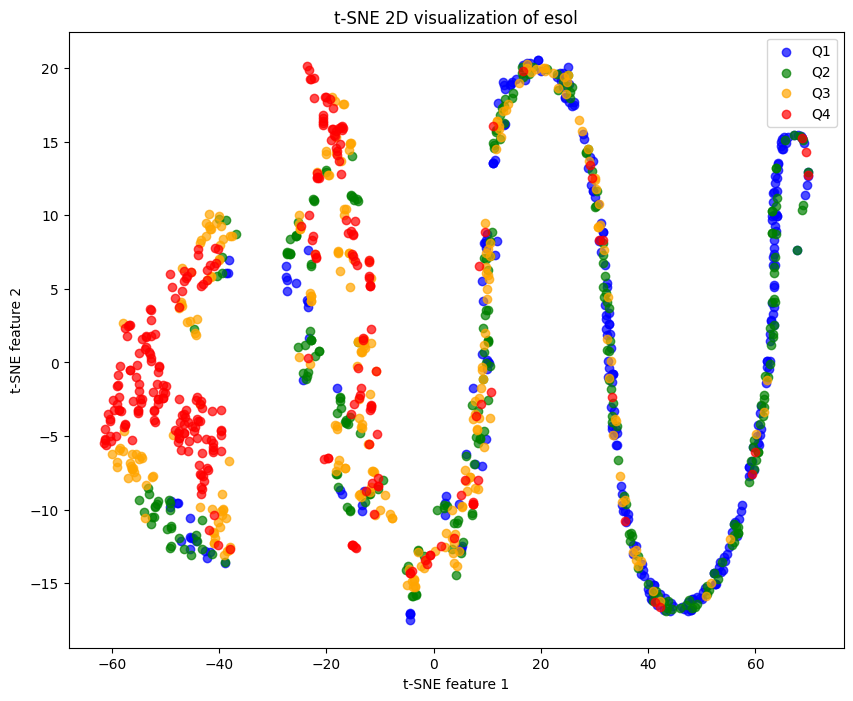

In [87]:
# 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

ax.scatter(X_tsne[idx_Q1, 0], X_tsne[idx_Q1, 1], label='Q1', c='blue', alpha=0.7)
ax.scatter(X_tsne[idx_Q2, 0], X_tsne[idx_Q2, 1], label='Q2', c='green', alpha=0.7)
ax.scatter(X_tsne[idx_Q3, 0], X_tsne[idx_Q3, 1], label='Q3', c='orange', alpha=0.7)
ax.scatter(X_tsne[idx_Q4, 0], X_tsne[idx_Q4, 1], label='Q4', c='red', alpha=0.7)

ax.set_title(f't-SNE 2D visualization of {df_name}')
ax.set_xlabel('t-SNE feature 1')
ax.set_ylabel('t-SNE feature 2')
ax.legend()
plt.show()

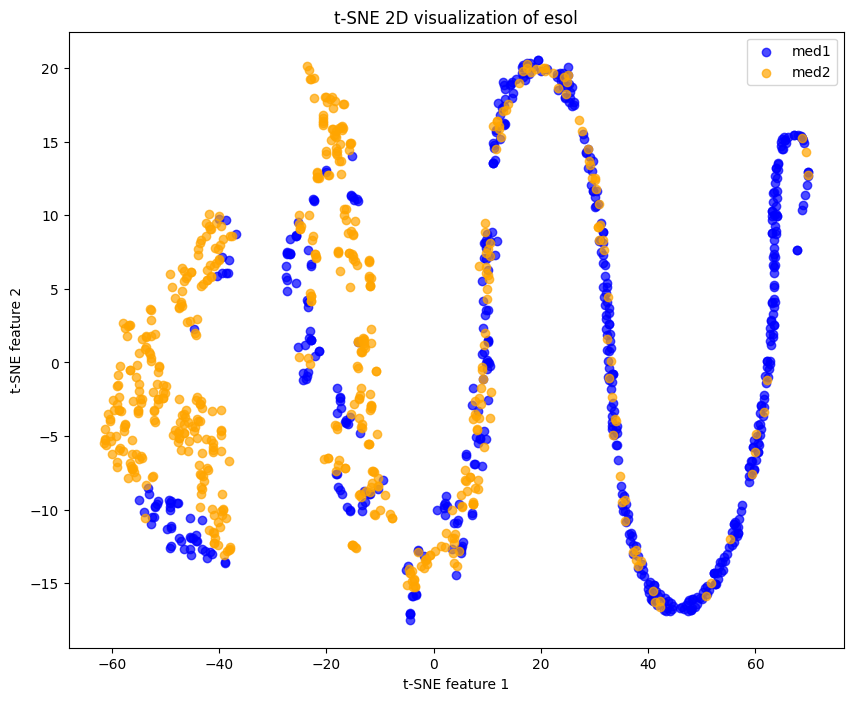

In [88]:
# 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

ax.scatter(X_tsne[idx_med1, 0], X_tsne[idx_med1, 1], label='med1', c='blue', alpha=0.7)
ax.scatter(X_tsne[idx_med2, 0], X_tsne[idx_med2, 1], label='med2', c='orange', alpha=0.7)

ax.set_title(f't-SNE 2D visualization of {df_name}')
ax.set_xlabel('t-SNE feature 1')
ax.set_ylabel('t-SNE feature 2')
ax.legend()
plt.show()

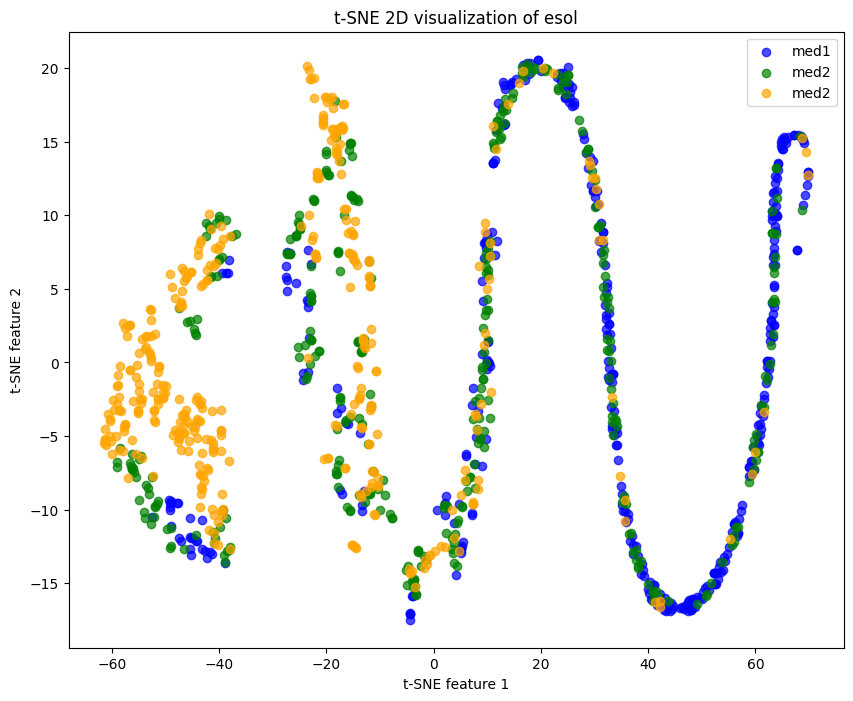

In [89]:
# 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

ax.scatter(X_tsne[idx_med4, 0], X_tsne[idx_med4, 1], label='med1', c='blue', alpha=0.7)
ax.scatter(X_tsne[idx_med5, 0], X_tsne[idx_med5, 1], label='med2', c='green', alpha=0.7)
ax.scatter(X_tsne[idx_med6, 0], X_tsne[idx_med6, 1], label='med2', c='orange', alpha=0.7)

ax.set_title(f't-SNE 2D visualization of {df_name}')
ax.set_xlabel('t-SNE feature 1')
ax.set_ylabel('t-SNE feature 2')
ax.legend()
plt.show()

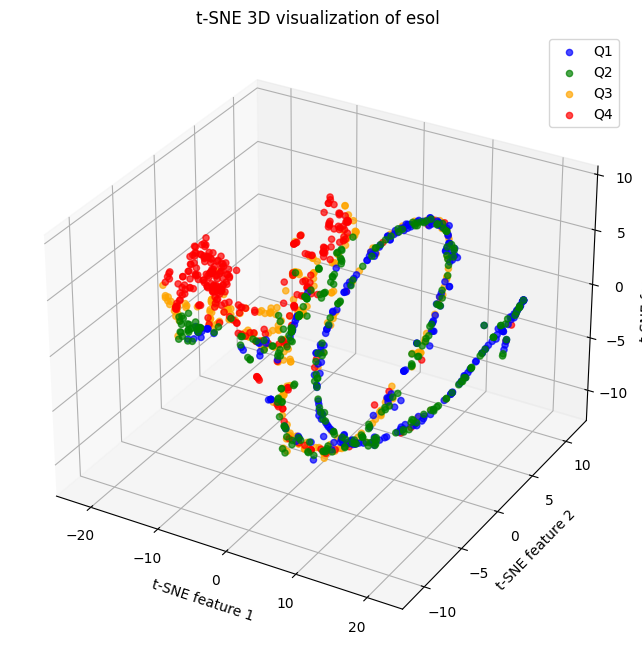

In [90]:

# 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_tsne3D[idx_Q1, 0], X_tsne3D[idx_Q1, 1], X_tsne3D[idx_Q1, 2], label='Q1', c='blue', alpha=0.7)
ax.scatter(X_tsne3D[idx_Q2, 0], X_tsne3D[idx_Q2, 1], X_tsne3D[idx_Q2, 2], label='Q2', c='green', alpha=0.7)
ax.scatter(X_tsne3D[idx_Q3, 0], X_tsne3D[idx_Q3, 1], X_tsne3D[idx_Q3, 2], label='Q3', c='orange', alpha=0.7)
ax.scatter(X_tsne3D[idx_Q4, 0], X_tsne3D[idx_Q4, 1], X_tsne3D[idx_Q4, 2], label='Q4', c='red', alpha=0.7)

ax.set_title(f't-SNE 3D visualization of {df_name}')
ax.set_xlabel('t-SNE feature 1')
ax.set_ylabel('t-SNE feature 2')
ax.set_zlabel('t-SNE feature 3')
ax.legend()
plt.show()

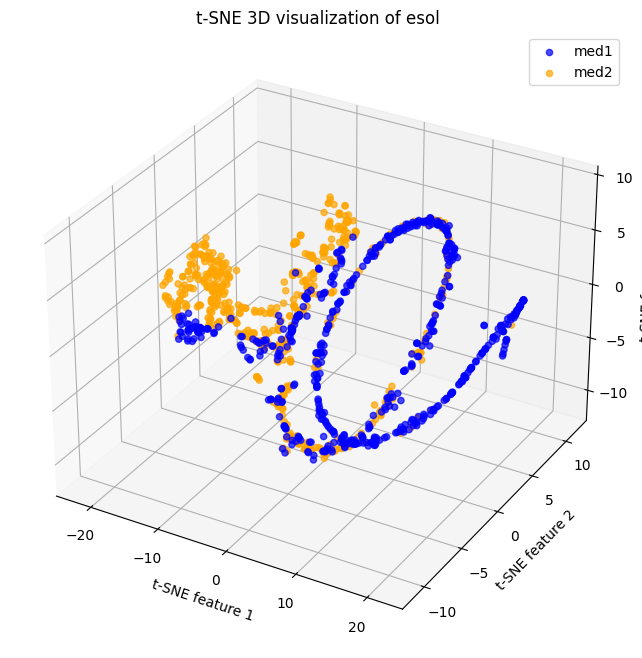

In [91]:
# 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_tsne3D[idx_med1, 0], X_tsne3D[idx_med1, 1], X_tsne3D[idx_med1, 2], label='med1', c='blue', alpha=0.7)
ax.scatter(X_tsne3D[idx_med2, 0], X_tsne3D[idx_med2, 1], X_tsne3D[idx_med2, 2], label='med2', c='orange', alpha=0.7)

ax.set_title(f't-SNE 3D visualization of {df_name}')
ax.set_xlabel('t-SNE feature 1')
ax.set_ylabel('t-SNE feature 2')
ax.set_zlabel('t-SNE feature 3')
ax.legend()
plt.show()

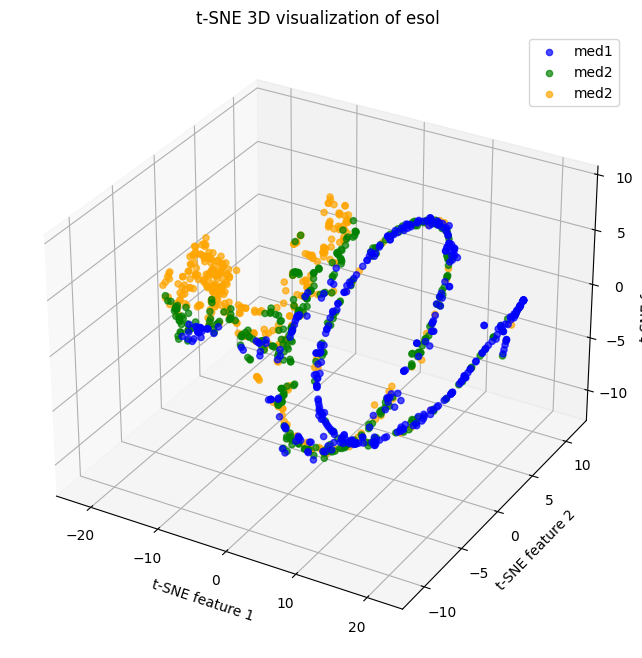

In [92]:
# 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_tsne3D[idx_med4, 0], X_tsne3D[idx_med4, 1], X_tsne3D[idx_med4, 2], label='med1', c='blue', alpha=0.7)
ax.scatter(X_tsne3D[idx_med5, 0], X_tsne3D[idx_med5, 1], X_tsne3D[idx_med5, 2], label='med2', c='green', alpha=0.7)
ax.scatter(X_tsne3D[idx_med6, 0], X_tsne3D[idx_med6, 1], X_tsne3D[idx_med6, 2], label='med2', c='orange', alpha=0.7)

ax.set_title(f't-SNE 3D visualization of {df_name}')
ax.set_xlabel('t-SNE feature 1')
ax.set_ylabel('t-SNE feature 2')
ax.set_zlabel('t-SNE feature 3')
ax.legend()
plt.show()

In [93]:
bins = pd.qcut(df_all_features['target'], q=4, labels=["Low", "Mid-low", "Mid-high", "High"])


In [94]:
bins = pd.cut(df_all_features['target'], bins=3, labels=["Low", "Mid-low", "Mid-high"])


In [95]:

# import seaborn as sns

# # t-SNE 임베딩
# X_embedded = TSNE(n_components=2, random_state=0).fit_transform(X)

# # 분위수로 나눔
# df_all_features['quantile_group'] = bins

# # 시각화
# sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=df_all_features['quantile_group'])
# plt.title("t-SNE projection with quantile-based color grouping")
# plt.show()


In [96]:
df_all_features.drop(['target'], axis=1)

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,10.253329,-1.701605,10.253329,0.486602,0.217518,457.432,430.216,457.158411,178,0,...,0,0,0,0,0,0,0,0,0,0
1,11.724911,-0.145880,11.724911,0.145880,0.811283,201.225,190.137,201.078979,76,0,...,0,0,0,0,0,0,0,0,0,0
2,10.020498,0.845090,10.020498,0.845090,0.343706,152.237,136.109,152.120115,62,0,...,0,0,0,0,0,0,0,0,0,0
3,2.270278,1.301055,2.270278,1.301055,0.291526,278.354,264.242,278.109550,102,0,...,0,0,0,0,0,0,0,0,0,0
4,2.041667,1.712963,2.041667,1.712963,0.448927,84.143,80.111,84.003371,26,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,10.999421,-4.317901,10.999421,1.916667,0.523506,197.381,196.373,195.890224,44,0,...,0,0,0,0,0,0,0,0,0,0
1124,11.337508,-0.705457,11.337508,0.123704,0.293876,219.266,206.162,219.067762,80,0,...,1,0,0,0,0,0,0,0,0,0
1125,5.174287,-1.984662,5.174287,1.011373,0.506070,246.359,231.239,245.997179,74,0,...,1,0,0,0,0,0,0,0,2,0
1126,2.222222,0.884259,2.222222,0.884259,0.444441,72.151,60.055,72.093900,32,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
from sklearn.cluster import KMeans
import numpy as np
target_reshaped = df_all_features.drop(['target'], axis=1).values


df_all_features['kmeans_bin'] = KMeans(n_clusters=4).fit_predict(target_reshaped)

c:\Programming\anaconda3\envs\cuda5\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Programming\anaconda3\envs\cuda5\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


In [98]:
df_all_features

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,target,kmeans_bin
0,10.253329,-1.701605,10.253329,0.486602,0.217518,457.432,430.216,457.158411,178,0,...,0,0,0,0,0,0,0,0,-0.770,0
1,11.724911,-0.145880,11.724911,0.145880,0.811283,201.225,190.137,201.078979,76,0,...,0,0,0,0,0,0,0,0,-3.300,0
2,10.020498,0.845090,10.020498,0.845090,0.343706,152.237,136.109,152.120115,62,0,...,0,0,0,0,0,0,0,0,-2.060,0
3,2.270278,1.301055,2.270278,1.301055,0.291526,278.354,264.242,278.109550,102,0,...,0,0,0,0,0,0,0,0,-7.870,0
4,2.041667,1.712963,2.041667,1.712963,0.448927,84.143,80.111,84.003371,26,0,...,0,0,0,0,0,1,0,0,-1.330,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,10.999421,-4.317901,10.999421,1.916667,0.523506,197.381,196.373,195.890224,44,0,...,0,0,0,0,0,0,0,0,-1.710,0
1124,11.337508,-0.705457,11.337508,0.123704,0.293876,219.266,206.162,219.067762,80,0,...,0,0,0,0,0,0,0,0,0.106,0
1125,5.174287,-1.984662,5.174287,1.011373,0.506070,246.359,231.239,245.997179,74,0,...,0,0,0,0,0,0,2,0,-3.091,0
1126,2.222222,0.884259,2.222222,0.884259,0.444441,72.151,60.055,72.093900,32,0,...,0,0,0,0,0,0,0,0,-3.180,0


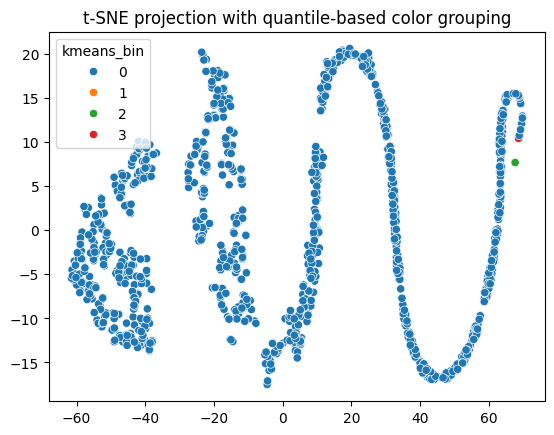

In [99]:

import seaborn as sns

# t-SNE 임베딩
X_embedded = TSNE(n_components=2, random_state=0).fit_transform(X)

# 분위수로 나눔

# 시각화
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=df_all_features['kmeans_bin'],palette='tab10')
plt.title("t-SNE projection with quantile-based color grouping")
plt.show()
